In [1]:
import numpy as np
import pandas as pd
import os

import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout

from tensorflow.keras.preprocessing.image import ImageDataGenerator,img_to_array,load_img


In [2]:
batch_size = 32
img_height = 224
img_width = 224

In [3]:
data_dir = 'E:/Preethi CityU/DS620ML/PE09_FaceMaskDetection/archive/data'

In [4]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size
)

Found 7553 files belonging to 2 classes.
Using 6043 files for training.


In [5]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size
)

Found 7553 files belonging to 2 classes.
Using 1510 files for validation.


In [6]:
class_names = train_ds.class_names
print(class_names)

num_classes = len(class_names)

['with_mask', 'without_mask']


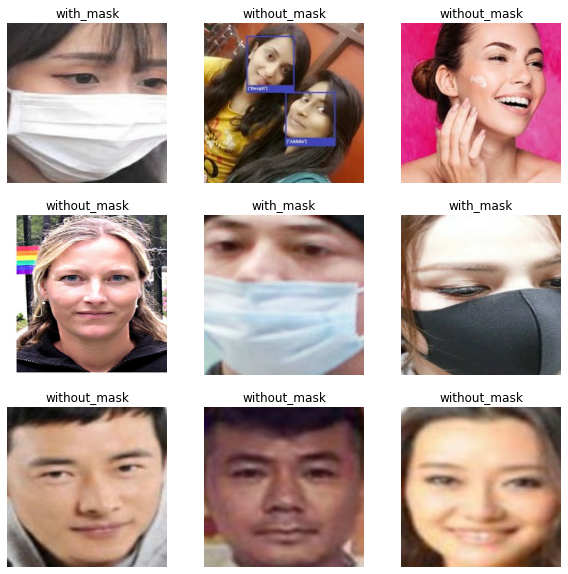

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

**Standardize the images by dividing all pixels by 255**

In [8]:
train_data_gen = ImageDataGenerator(rotation_range=30,
                                    width_shift_range=0.02,
                                    height_shift_range=0.02,
                                    zoom_range=[0.8,1.2],
                                    horizontal_flip=True,
                                    rescale=1/255
                                   )

val_data_gen = ImageDataGenerator(rescale=1/255)
test_data_gen = ImageDataGenerator(rescale=1/255)

**Configure the dataset for performance**

Let's make sure to use buffered prefetching so we can yield data from disk without having I/O become blocking. These are two important methods you should use when loading data.

`.cache()` keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.

`.prefetch()` overlaps data preprocessing and model execution while training.

In [9]:
training_data = train_data_gen.flow_from_directory(data_dir, target_size=(200, 200), color_mode='rgb', class_mode='binary', batch_size=32)

Found 7553 images belonging to 2 classes.


**Train the Model**

In [10]:
model = Sequential()

model.add(Conv2D(filters=64, kernel_size=3, strides=1, activation='relu', input_shape=training_data.image_shape))
model.add(Conv2D(filters=64, kernel_size=3, strides=1, activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding='same'))


model.add(Conv2D(filters=128, kernel_size=3, strides=1, activation='relu'))
model.add(Conv2D(filters=128, kernel_size=3, strides=1, activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding='same'))

model.add(Conv2D(filters=256, kernel_size=3, strides=1, activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding='same'))

model.add(Conv2D(filters=512, kernel_size=3, strides=1, activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding='same'))


model.add(Flatten())

model.add(Dense(units=512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units=1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units=1, activation='sigmoid'))


model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 198, 198, 64)      1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 196, 196, 64)      36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 98, 98, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 96, 96, 128)       73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 94, 94, 128)       147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 47, 47, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 45, 45, 256)       2

In [12]:
history = model.fit(training_data, batch_size=32, epochs=5 ) #Fitting the data

Epoch 1/5
138/237 [================>.............] - ETA: 12:10 - loss: 0.5771 - accuracy: 0.6664C:\Users\preet\AppData\Local\Programs\Python\Python39\lib\site-packages\PIL\Image.py:962: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
237/237 [==============================] - 4019s 17s/step - loss: 0.4789 - accuracy: 0.7465
Epoch 2/5
237/237 [==============================] - 1700s 7s/step - loss: 0.2543 - accuracy: 0.9032
Epoch 3/5
237/237 [==============================] - 1699s 7s/step - loss: 0.2163 - accuracy: 0.9212
Epoch 4/5
237/237 [==============================] - 1710s 7s/step - loss: 0.2294 - accuracy: 0.9161
Epoch 5/5
237/237 [==============================] - 1769s 7s/step - loss: 0.1892 - accuracy: 0.9337


In [13]:
loss_df = pd.DataFrame(history.history)   #Storing the result of train data in a new dataframe and visualizing it
loss_df

,loss,accuracy
0,0.478943,0.746458
1,0.254345,0.903217
2,0.216292,0.921223
3,0.229375,0.916060
4,0.189202,0.933669


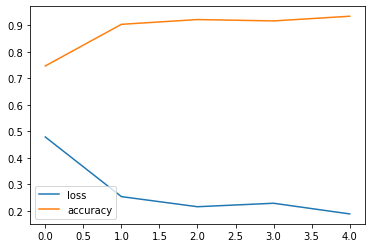

In [14]:
loss_df.plot()
plt.legend(loc=3)   #Plotting the data